In [1]:
import pystac_client
import planetary_computer as pc

#import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import shapely
import os
from shapely.geometry import box


In [2]:
# geometry = geometry that NAIP scenes must intersect
# year = year of the NAIP scenes you want
# returns a list of the items of NAIP scenes from year that intersect geometry
def query_geom(geom, year):

    date_range = str(year)+'-01-01/'+str(year)+'-12-31'

    catalog = pystac_client.Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1")

    search = catalog.search(
        collections=["naip"], 
        intersects=geom, 
        datetime=date_range)
    
    items =list(search.get_items()) 
    if len(items)==0:
        return None
    return items


In [4]:
#fp = os.path.join(os.getcwd(),'sb_county_coast','sb_county_coast.shp')

# ---------------------------------------
# os.chdir("..")
# fp = os.path.join(os.getcwd(),'shapefiles_n_rasters','SB_geometry','SB_only.shp')
# os.chdir("iceplant_detection")
# os.getcwd()
# ---------------------------------------

geom = gpd.read_file(fp)

,NAME_PCASE,NAME_UCASE,FMNAME_PC,FMNAME_UC,ABBREV,NUM,ABCODE,FIPS,ANSI,ISLAND,Shape_Leng,Shape_Area,geometry
0,Santa Barbara,SANTA BARBARA,Santa Barbara County,SANTA BARBARA COUNTY,SBA,42,c042,083,083,N,424655.163272,6.608866e+09,"POLYGON ((-7248.153 -322621.781, -7240.234 -32..."
1,Santa Barbara,SANTA BARBARA,Santa Barbara County,SANTA BARBARA COUNTY,SBA,42,c042,083,083,Y,220.962192,3.665768e+03,"POLYGON ((-60843.500 -346204.000, -60854.609 -..."
2,Santa Barbara,SANTA BARBARA,Santa Barbara County,SANTA BARBARA COUNTY,SBA,42,c042,083,083,Y,559.332846,8.479405e+03,"POLYGON ((-58512.125 -362150.188, -58526.457 -..."
3,Santa Barbara,SANTA BARBARA,Santa Barbara County,SANTA BARBARA COUNTY,SBA,42,c042,083,083,Y,859.536811,2.466295e+04,"POLYGON ((28638.146 -401237.438, 28642.877 -40..."
4,Santa Barbara,SANTA BARBARA,Santa Barbara County,SANTA BARBARA COUNTY,SBA,42,c042,083,083,Y,120137.609955,2.502277e+08,"POLYGON ((7485.788 -439053.938, 7488.938 -4389..."
5,Santa Barbara,SANTA BARBARA,Santa Barbara County,SANTA BARBARA COUNTY,SBA,42,c042,083,083,Y,44315.149119,3.852854e+07,"POLYGON ((-39139.164 -440591.344, -39120.691 -..."
6,Santa Barbara,SANTA BARBARA,Santa Barbara County,SANTA BARBARA COUNTY,SBA,42,c042,083,083,Y,1736.785102,1.533134e+05,"POLYGON ((-30672.670 -439903.344, -30699.912 -..."
7,Santa Barbara,SANTA BARBARA,Santa Barbara County,SANTA BARBARA COUNTY,SBA,42,c042,083,083,Y,824.624731,1.531302e+04,"POLYGON ((-38500.484 -439899.375, -38510.887 -..."
8,Santa Barbara,SANTA BARBARA,Santa Barbara County,SANTA BARBARA COUNTY,SBA,42,c042,083,083,Y,584.075619,1.794771e+04,"POLYGON ((-40617.293 -439921.594, -40624.473 -..."
9,Santa Barbara,SANTA BARBARA,Santa Barbara County,SANTA BARBARA COUNTY,SBA,42,c042,083,083,Y,888.098963,4.262273e+04,"POLYGON ((-40294.981 -440075.188, -40312.644 -..."


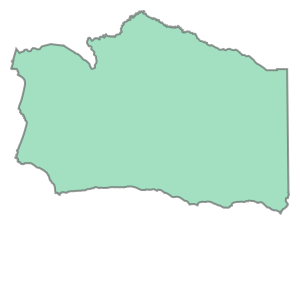

In [15]:
geom.geometry[0]

In [ ]:
coast_scenes = query_geom(geom.geometry[0],2018)
coast_scenes

In [5]:
def make_bbox(item):
    c = item.properties['proj:bbox']
    return box(c[0],c[1],c[2],c[3])

In [7]:
# make dataframe with collected scenes and relevant info
df = pd.DataFrame(coast_scenes, columns = ['item'])
df['date']=df.item.apply(lambda item : item.properties['datetime'])
df['crs']=df.item.apply(lambda item : item.properties['proj:epsg'])
df['bbox']=df.item.apply(make_bbox)
df.shape

(30, 4)

In [8]:
def group_flight(df,date):
    same_date = df[df['date']==date]
    
    crs_list = same_date.crs.unique()
    polygons = []
    for crs in crs_list:
        same_crs = same_date[same_date['crs']==crs]
        area = shapely.ops.unary_union(same_crs.bbox)
        gdf = gpd.GeoDataFrame({'geometry':[area]}, 
                               crs='EPSG:'+str(crs))
        gdf.to_crs('EPSG:4326',inplace=True)
        polygons.append(gdf.geometry[0])

        flight = shapely.ops.unary_union(polygons)

    return flight

def flight_paths(df):
    dates = df.date.unique()
    flights = []
    for date in dates:
        flights.append(group_flight(df,date))
    gdf = gpd.GeoDataFrame({'date':dates, 'geometry':flights},
                     crs = 'EPSG:4326')
    return gdf

In [9]:
flights = flight_paths(df)

In [10]:
flights

,date,geometry
0,2018-09-13T00:00:00Z,"MULTIPOLYGON (((-120.50354 34.43618, -120.5016..."
1,2018-07-24T00:00:00Z,"MULTIPOLYGON (((-119.50156 34.30983, -119.5034..."
2,2018-07-22T00:00:00Z,"MULTIPOLYGON (((-119.81405 34.37217, -119.8140..."
3,2018-07-15T00:00:00Z,"POLYGON ((-119.99846 34.43456, -119.99607 34.5..."


In [11]:
flights.to_file(os.path.join(os.getcwd(),'training_set','aux_data','flights_coast.shp'))

/srv/conda/envs/notebook/lib/python3.8/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
